In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

# Figure

## Panel : Example Trajectories

In [359]:
def traj_from_file(temp, traj):
    #grp = file[f"/behaviour/{temp}"]
    #x = grp["xpos"][traj,:]
    #y = grp["ypos"][traj,:]
    #dtheta = grp["dtheta"][traj,:]
    dtheta, x, y = load_full_traj(bDATAPATH, temp, traj)

    x -= x[0]
    y -= y[0]
    if np.nanmean(x) < x[0]:
        x = -x
    rot = np.pi-np.arctan2(y[0]-np.nanmean(y),x[0]-np.nanmean(x))
    c, s = np.cos(rot), np.sin(rot)
    R = np.array(((c, -s), (s, c)))
    x,y = R@np.c_[x,y].T
    
    dtheta = np.insert(dtheta,-1,0)
    return x,y,dtheta

### Searching for best trajectories

In [18]:
import ipywidgets as widgets
def plot_traj(i,T):
    fig, ax = plt.subplots(figsize=(4,2))
    ax.axis("off")
    #ax.set_aspect("equal")
    ax.set_xlim(-10,+100)
    ax.set_ylim(-50,+50)

    x, y, dtheta = traj_from_file(T, i)
    ax.plot(x,y,
            color=TEMPS_COLS[T], zorder=1,
    )
    order = np.argsort(np.abs(dtheta))
    ax.scatter(
        x[order],y[order],
        c=dtheta[order],
        edgecolors=TEMPS_COLS[T],linewidths=0.5,
        #linewidths=0,
        s=10, 
        vmin=-DTHETA_LIM, vmax=+DTHETA_LIM, cmap=DTHETA_CMAP, 
        zorder=2,
        #alpha=0.75
    )

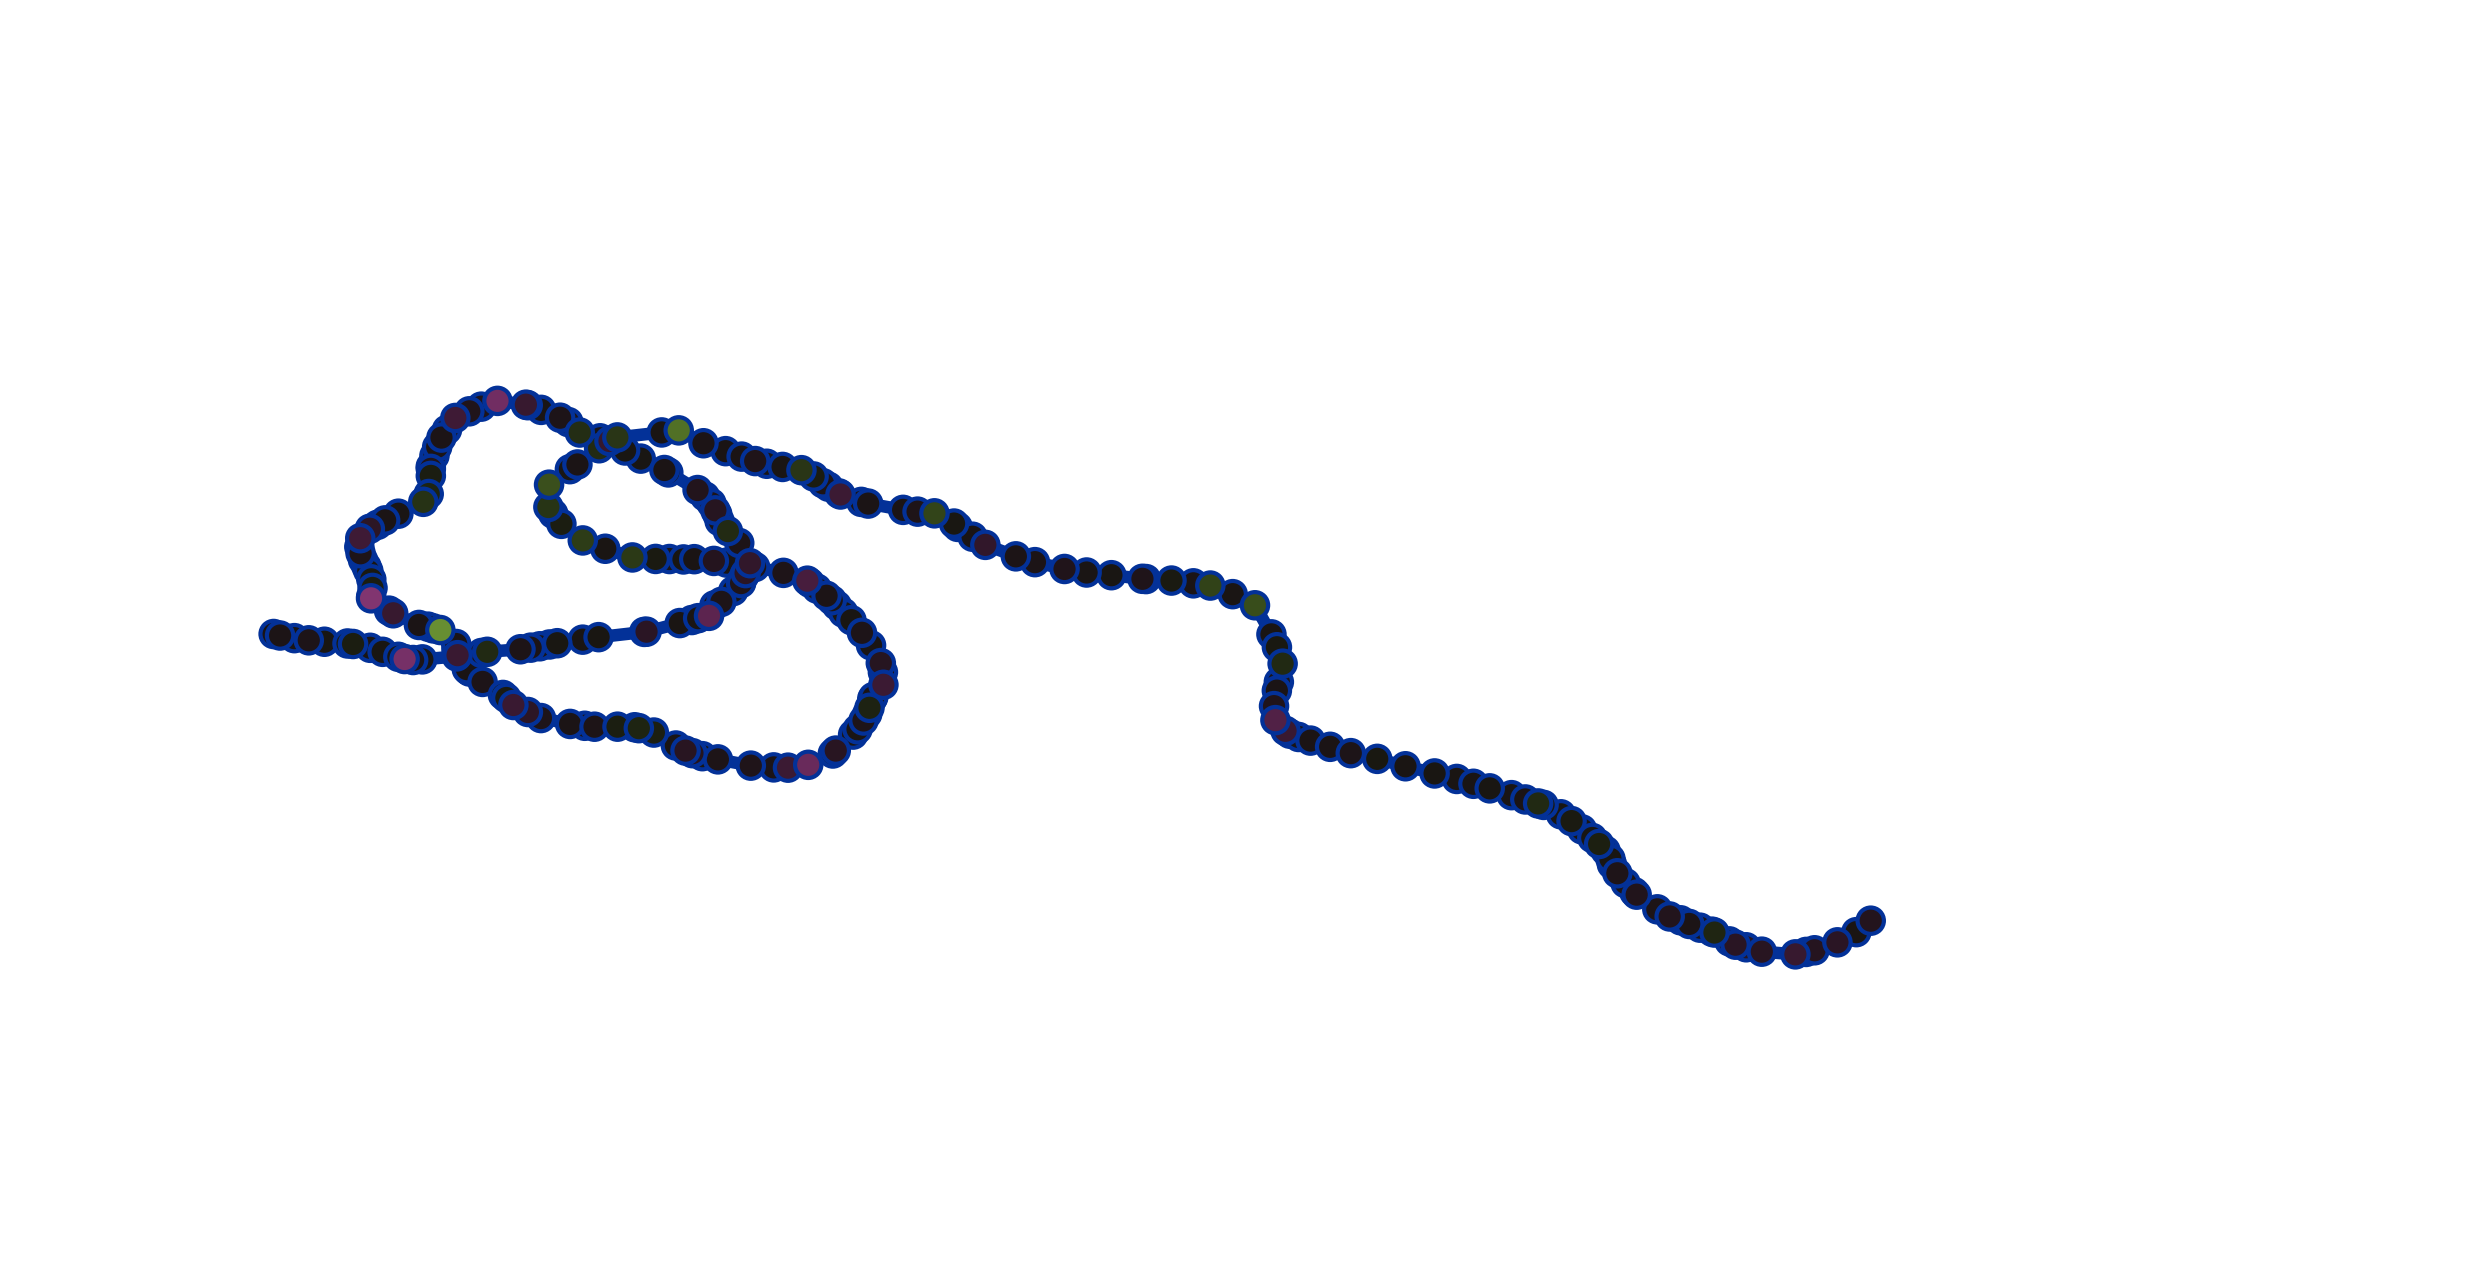

interactive(children=(IntSlider(value=50, description='i'), Dropdown(description='T', options=(18, 22, 26, 30,…

<function __main__.plot_traj(i, T)>

In [19]:
widgets.interact(plot_traj, i=(0,100), T=TEMPS)

### Plot selected trajs

In [360]:
DTHETA_LIM = 90

Text(5, -17.243446456703058, '10mm')

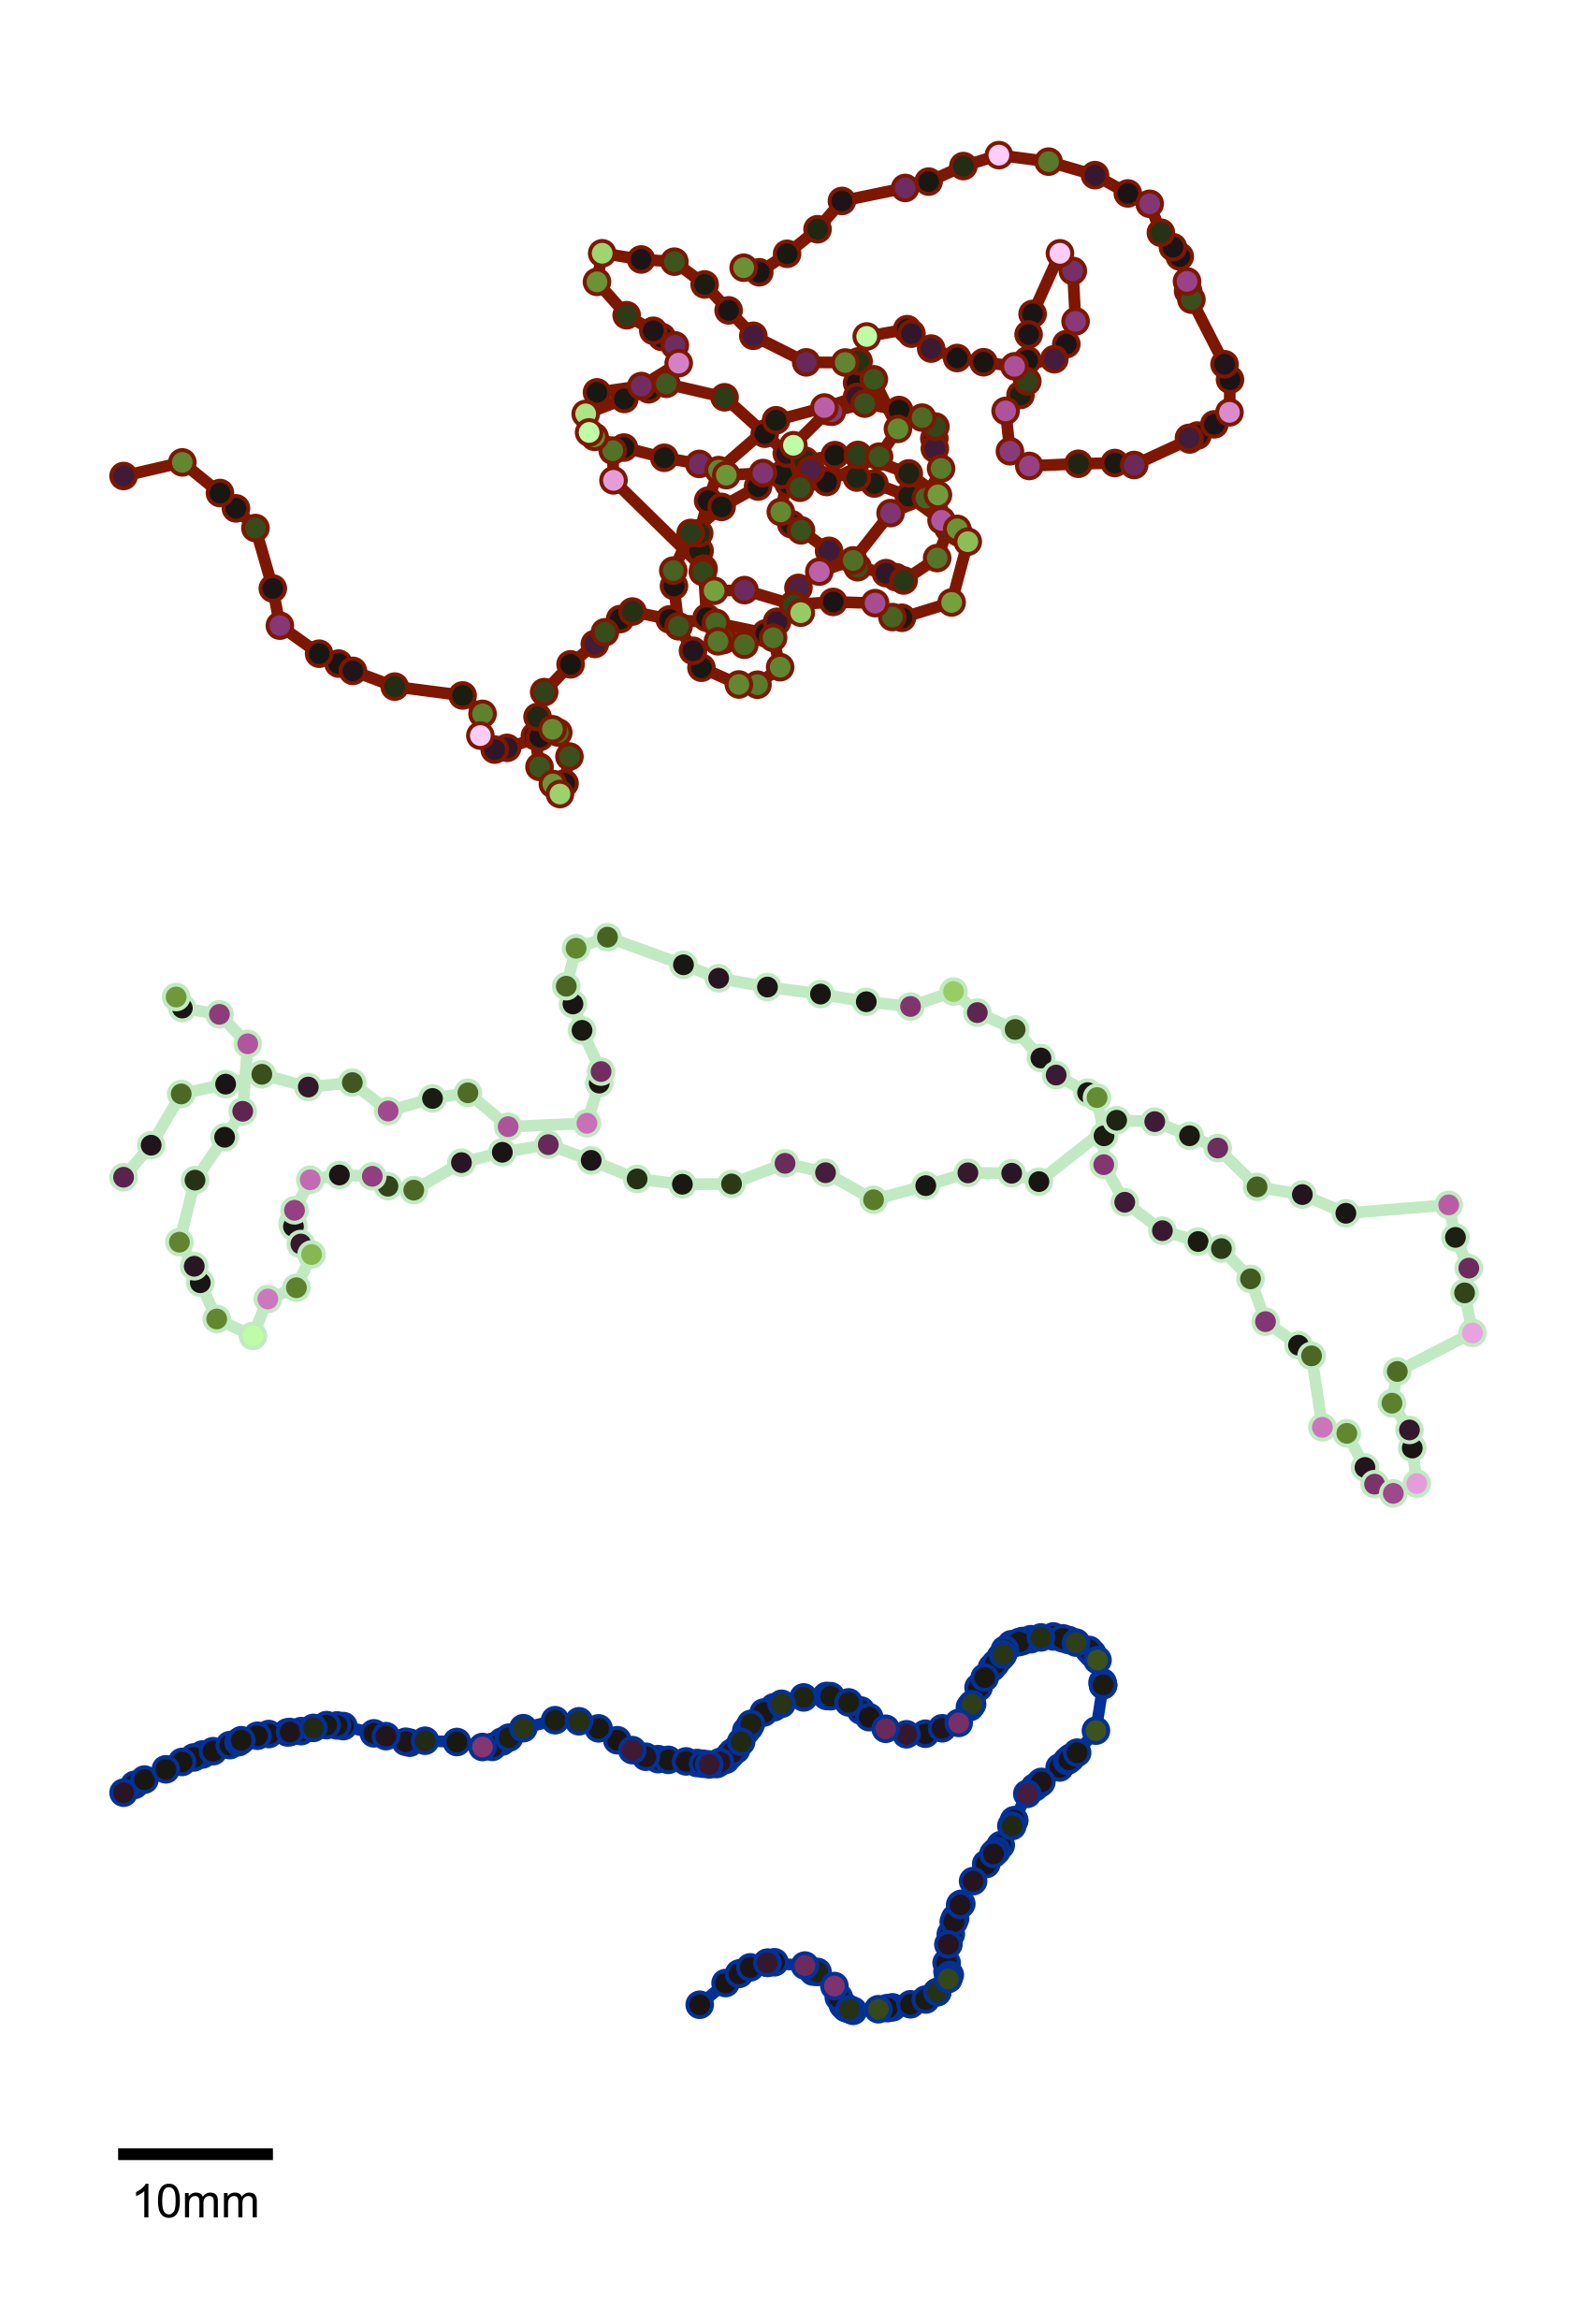

In [361]:
Temps = [18,26,33]
trajs_idxs = [62,42,55]

pady = 10

fig, ax = plt.subplots(figsize=(4*2,2*2))
ax.axis("off")
ax.set_aspect("equal")
dy = 0

X,Y,DTHETA = [],[],[]
for t,T in enumerate(Temps):
    x, y, dtheta = traj_from_file(T, trajs_idxs[t])
    X.append(x)
    Y.append(y)
    DTHETA.append(dtheta)
    if t > 0:
        dy = np.abs(np.nanmax(Y[t-1]))+np.abs(np.nanmin(Y[t]))
    Y[t] += dy + pady

    ax.plot(X[t],Y[t],
            color=TEMPS_COLS[T], zorder=1,
    )
    order = np.argsort(np.abs(DTHETA[t]))
    ax.scatter(
        X[t][order],Y[t][order],
        c=DTHETA[t][order],
        edgecolors=TEMPS_COLS[T],linewidths=0.5,
        #linewidths=0,
        s=10, 
        vmin=-DTHETA_LIM, vmax=+DTHETA_LIM, cmap=DTHETA_CMAP, 
        zorder=2,
        #alpha=0.75
    )
ymin = np.nanmin(Y[0]) - pady
ax.plot([0,10],[ymin,ymin])
ax.text(5,ymin-2,"10mm",ha="center", va="top")

fig.savefig("panels/Fig1/example_trajectories.svg")

## dTheta colorbar

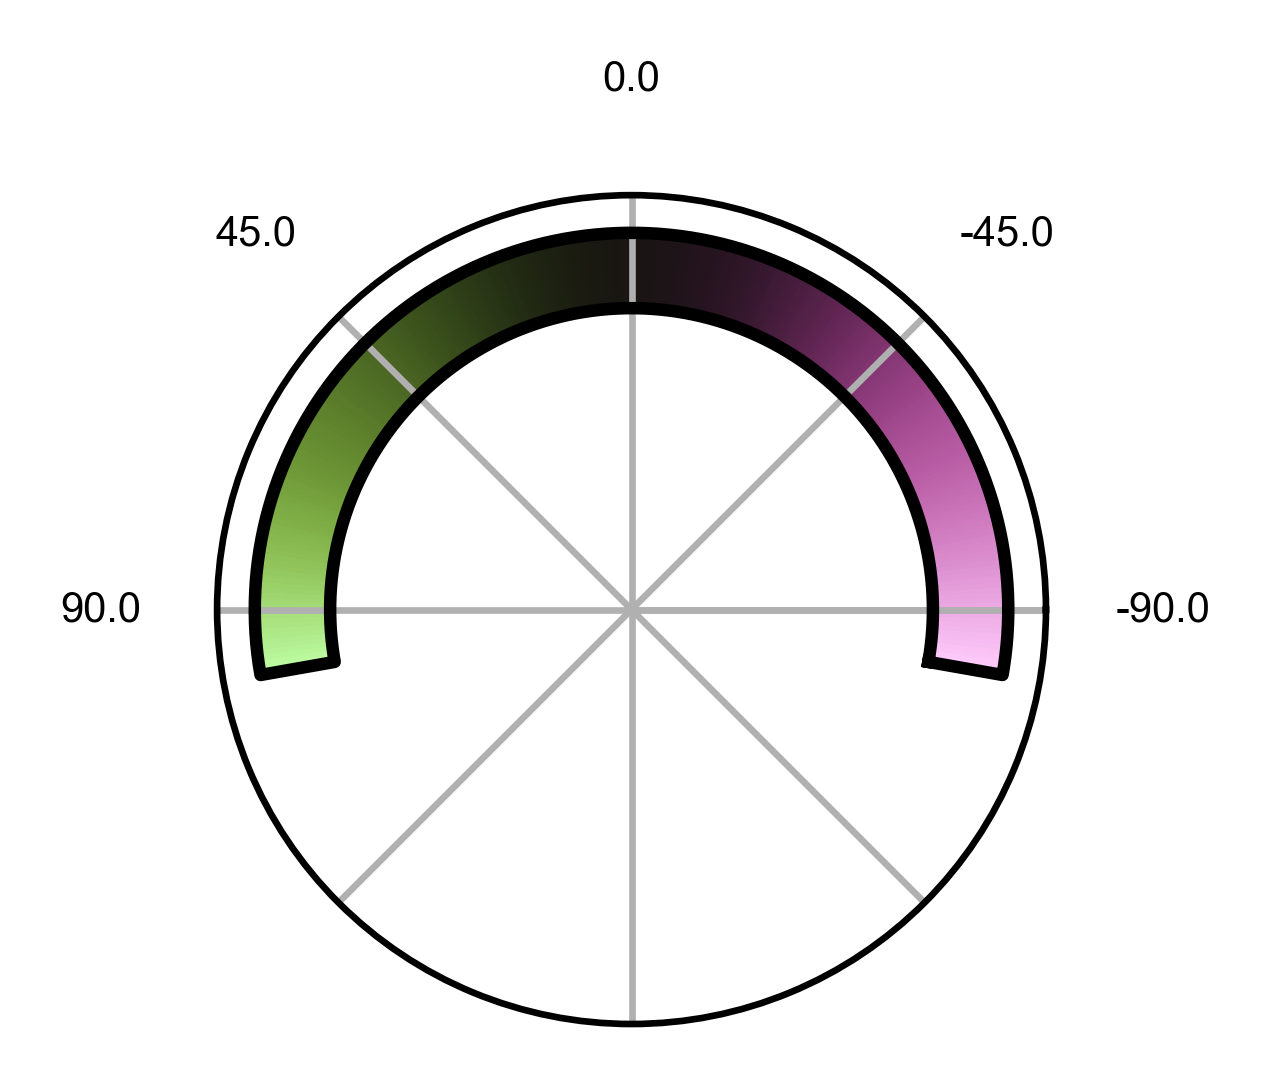

In [12]:
n = 500
R1,R2 = 0.8,1
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#ax.axis("off")
ax.set_yticks([])
ax.set_ylim(0,R2*1.1)
ax.spines['end'].set_visible(False)

angles = np.deg2rad(np.linspace(-DTHETA_LIM, +DTHETA_LIM, n) + 90)
ang_lab = np.linspace(0, +360, 9)
ax.set_xticks(
    np.deg2rad(ang_lab), 
    np.where((ang_lab-90 > -100) * (ang_lab-90<+100),ang_lab-90,"")
)

r = np.linspace(R1,R2,20)
rg, ag = np.meshgrid(r,angles)  
ax.pcolormesh(angles, r, ag.T, cmap=DTHETA_CMAP, rasterized=True, zorder=1)

outline_r = np.r_[np.ones(n)*R1, np.ones(n)*R2, R1]
outline_a = np.r_[angles, angles[::-1],angles[0]]
ax.plot(outline_a, outline_r, color="k", zorder=2)

fig.savefig("panels/Fig1/dtheta_colorbar.svg")

## Panel : Reorientation Histograms

In [363]:
from scipy.signal import savgol_filter

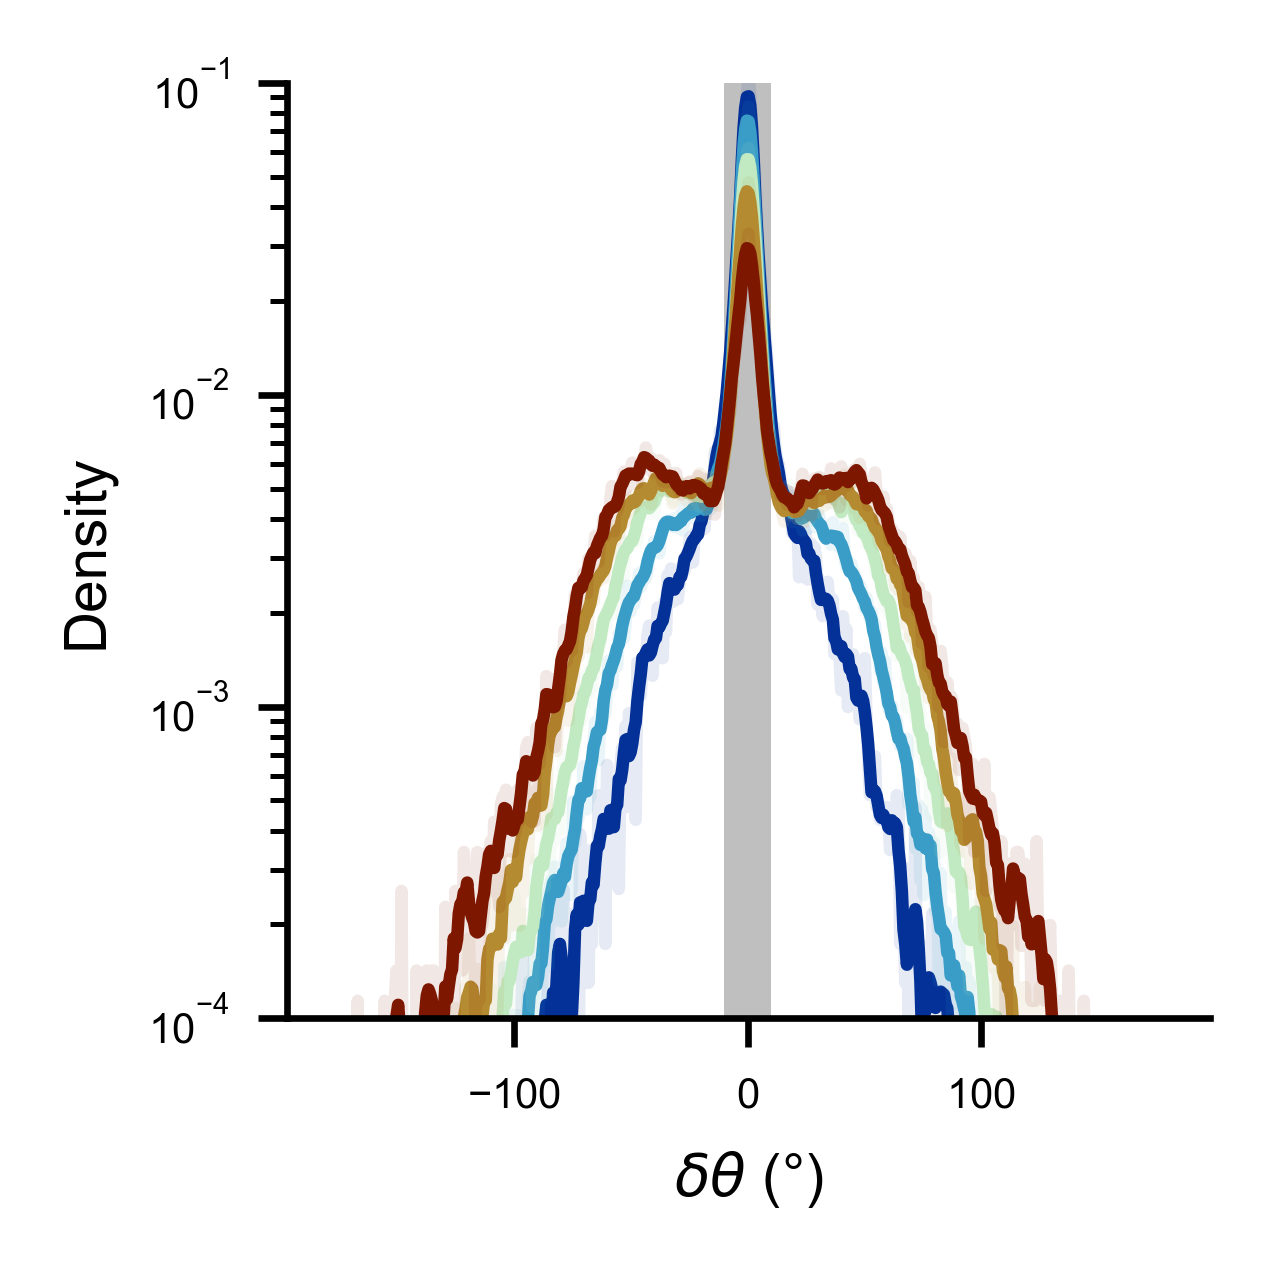

In [364]:
bins = np.linspace(-180, +180,500)

fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(1.e-4,1.e-1)
ax.set_xlabel(r"$\delta \theta$ (°)")
ax.set_ylabel("Density")

for temp in TEMPS:
    dthetas = np.concatenate(load_sequences(bDATAPATH, temp))
    h,_ = np.histogram(dthetas.ravel(), bins, density=True)
    ax.plot(bins[1:], h, color=TEMPS_COLS[temp], alpha=0.1)
    ax.plot(bins[1:], savgol_filter(h,10,2), color=TEMPS_COLS[temp], alpha=1)

ax.fill_betweenx(
    [1.e-4,1.e-1], 
    [-DTHETA_THRESH,-DTHETA_THRESH], 
    [+DTHETA_THRESH,+DTHETA_THRESH], 
    color="grey", alpha=0.5, linewidth=0
)

fig.savefig("panels/Fig1/dtheta_hists.svg")

## Temperature Colorbar

In [3]:
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap

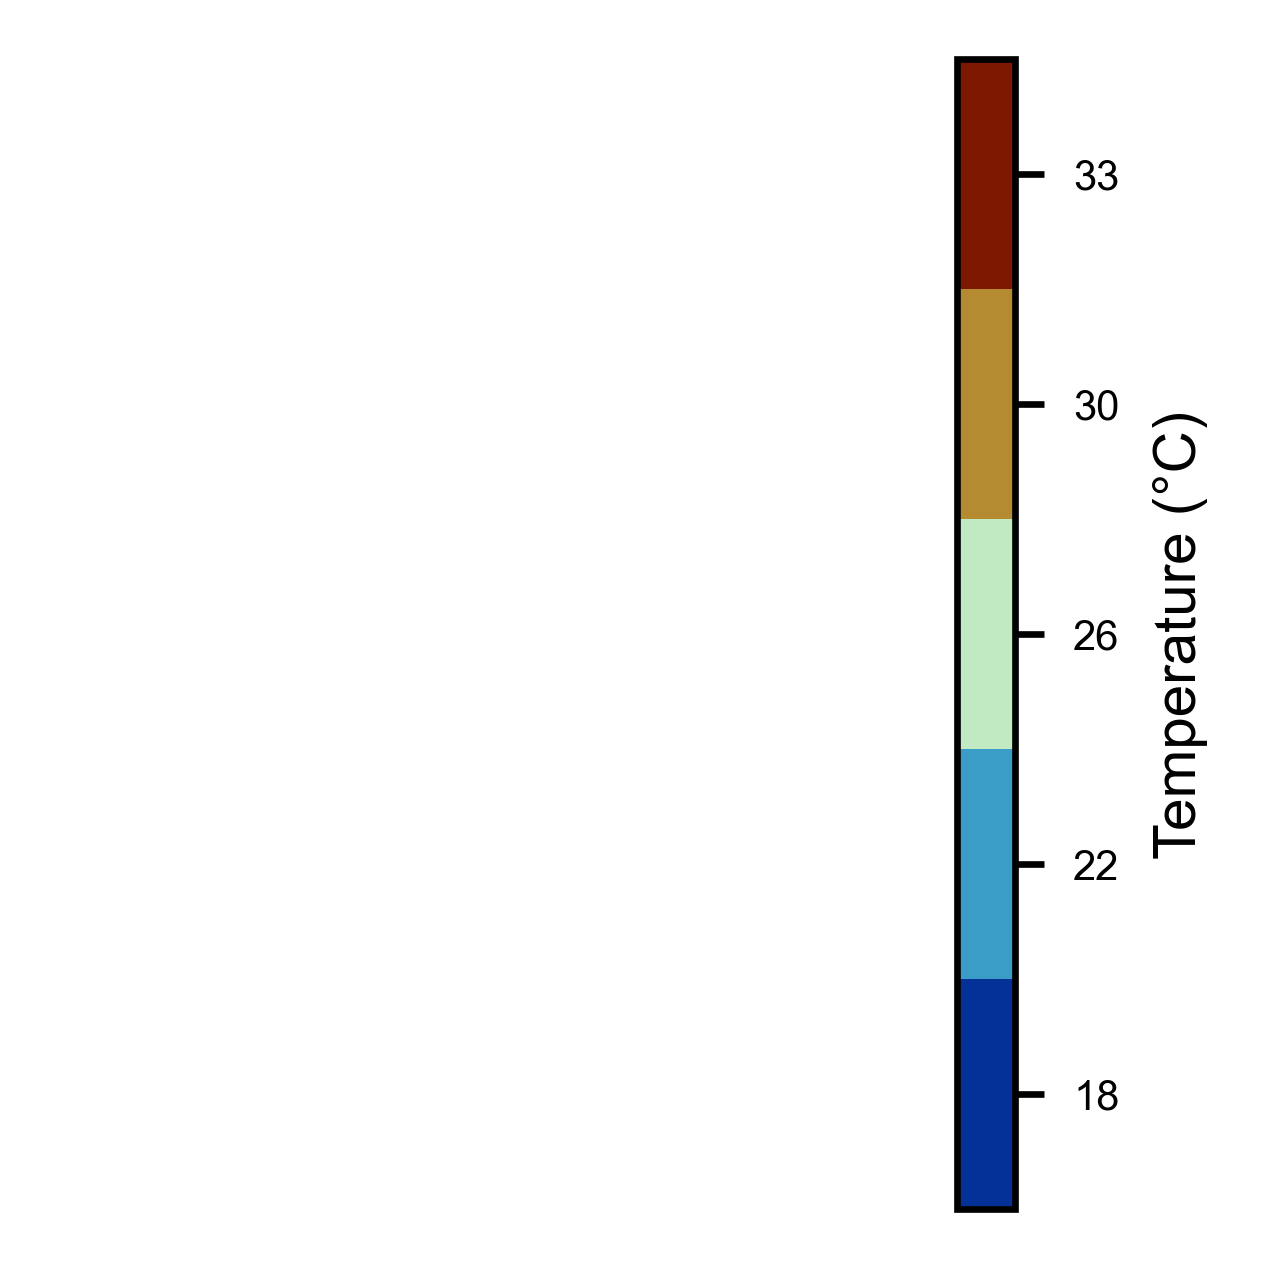

In [5]:
fig, ax = plt.subplots()
ax.axis("off")
cbar = fig.colorbar(
    cm.ScalarMappable(
        cmap=LinearSegmentedColormap.from_list("tempcol", list(TEMPS_COLS.values()), N=len(TEMPS))
    ), 
    ax=ax,
    ticks=np.arange(0.1,1,1/len(TEMPS)),
    label="Temperature (°C)"
)
cbar.set_ticklabels(TEMPS)

fig.savefig("panels/Fig1/temperature_colorbar.svg")

## ARTR activity

In [3]:
artr = ALL_ARTRs[3]

In [4]:
mL, mR, L,R,dt = load_ARTR(nDATAPATH, *artr)

(6.0, 14.0)

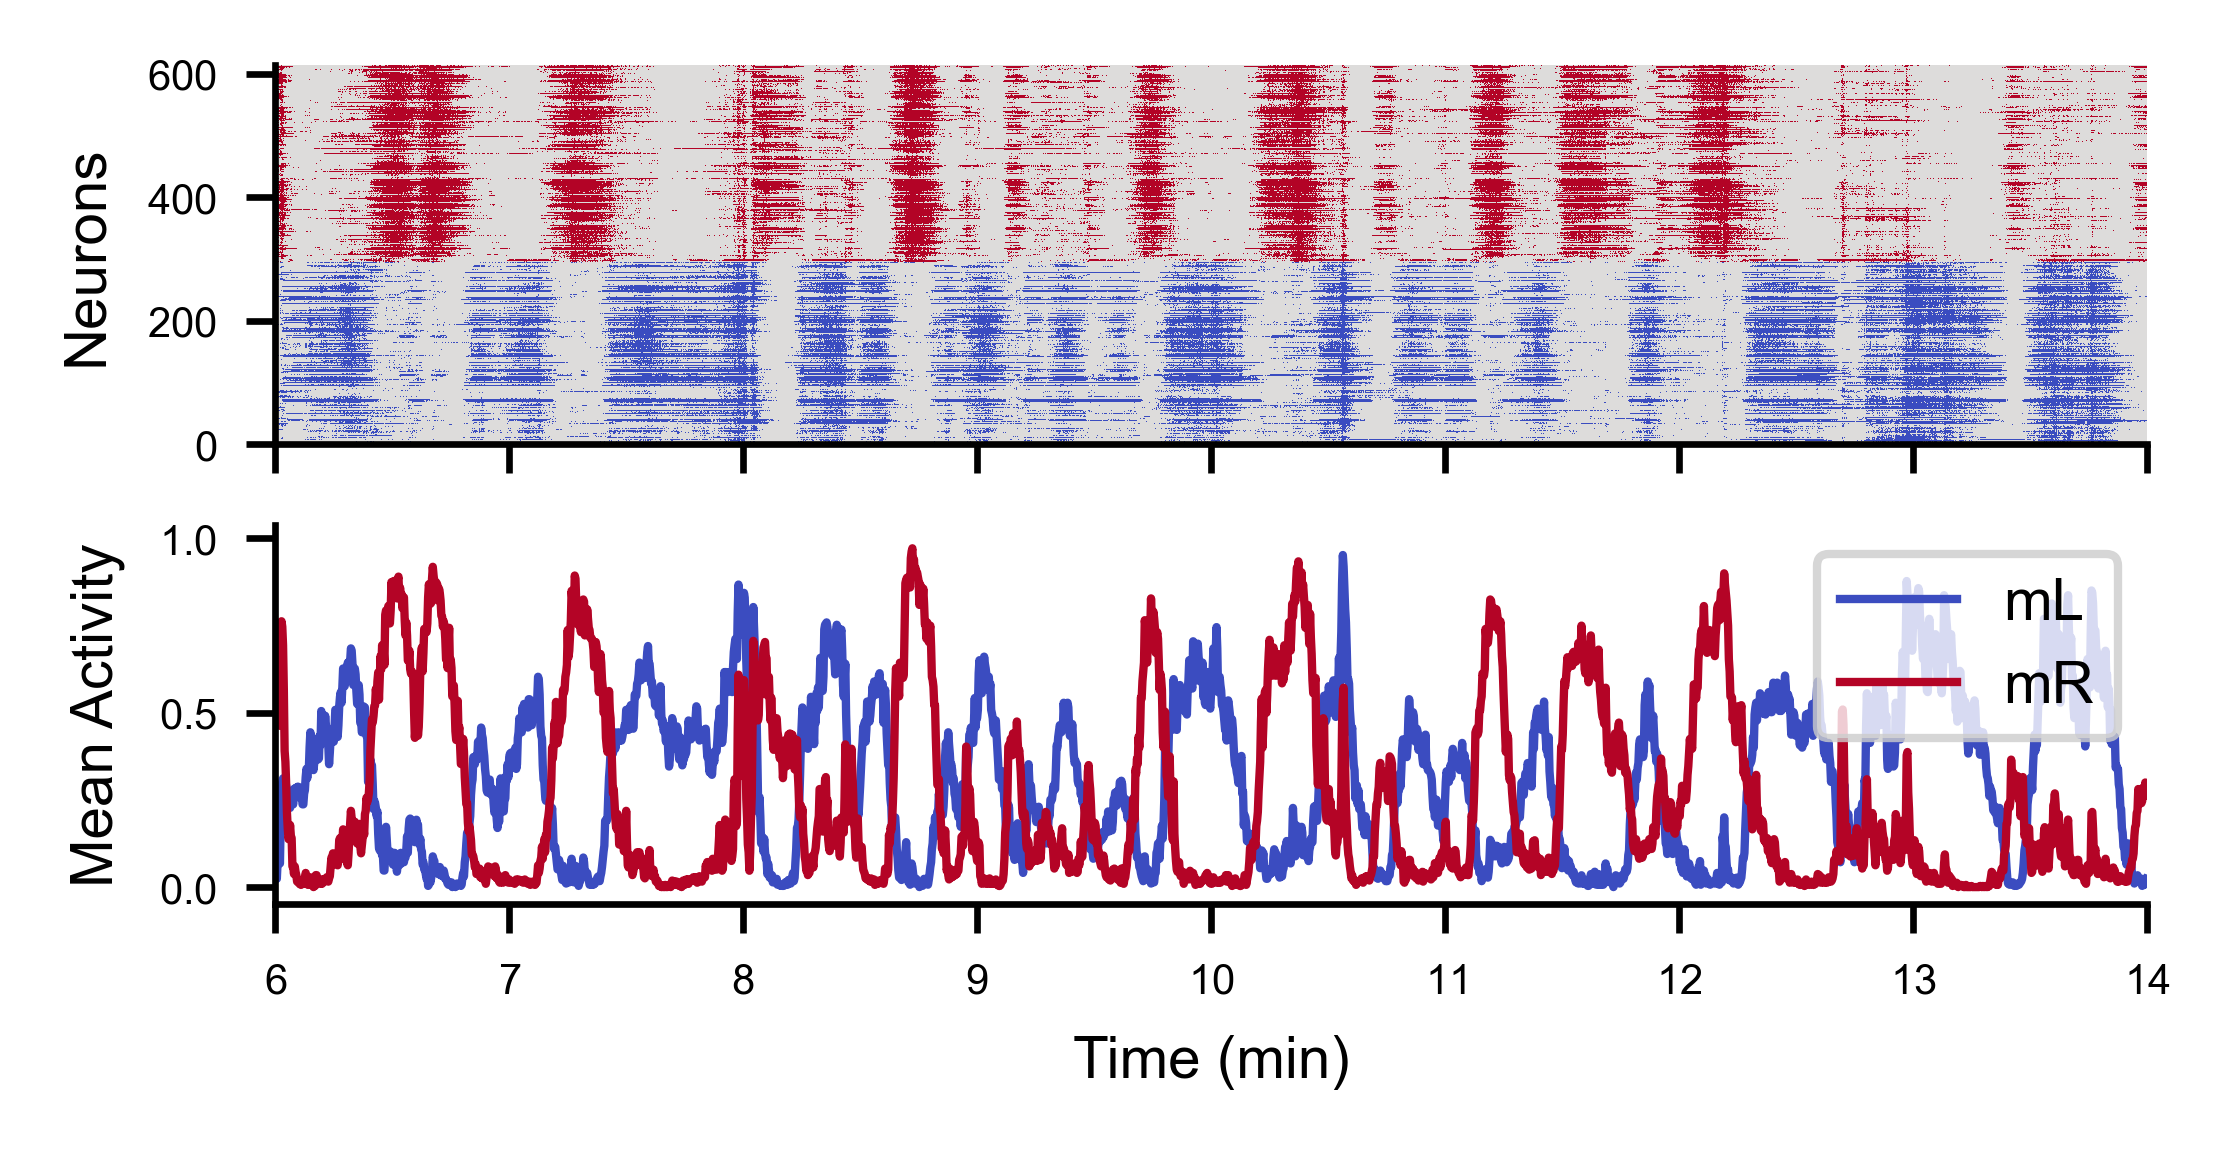

In [5]:
fig, axs = plt.subplots(nrows=2, figsize=(2*1.8,1.8), sharex=True)
t = np.arange(0,len(mL)*dt, dt)
ax = axs[0]
ax.imshow(
    np.c_[-L.astype(np.int_),R.astype(np.int_)].T, 
    cmap=ARTR_CMAP, vmin=-1, vmax=+1,
    extent=(0, t[-1]/60, 0, L.shape[1] + R.shape[1]),
)
ax.set_ylabel("Neurons")

ax = axs[1]
ax.plot(t/60, mL, color=COLOR_Lartr, linewidth=1, label="mL")
ax.plot(t/60, mR, color=COLOR_Rartr, linewidth=1, label="mR")
ax.set_xlabel("Time (min)")
ax.set_ylabel("Mean Activity")
ax.legend()

ax.set_xlim(6,14)
fig.savefig("panels/Fig1/ARTR.svg")

## ARTR Magnitization

In [6]:
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

In [11]:
mLRall = np.concatenate([load_ARTR_magnet(nDATAPATH, *artr) for artr in ALL_ARTRs])
mLRall.shape

(255163, 2)

In [325]:
def find_level(X, q, ls=np.linspace(0,100,10000)):
    ps = []
    for l in ls:
        inside = X > l
        ins = z[inside].sum()
        outs = z[~inside].sum()
        ps.append(ins/(ins+outs))
    ps = np.array(ps)
    return ls[np.argmin(np.abs(ps-q))]

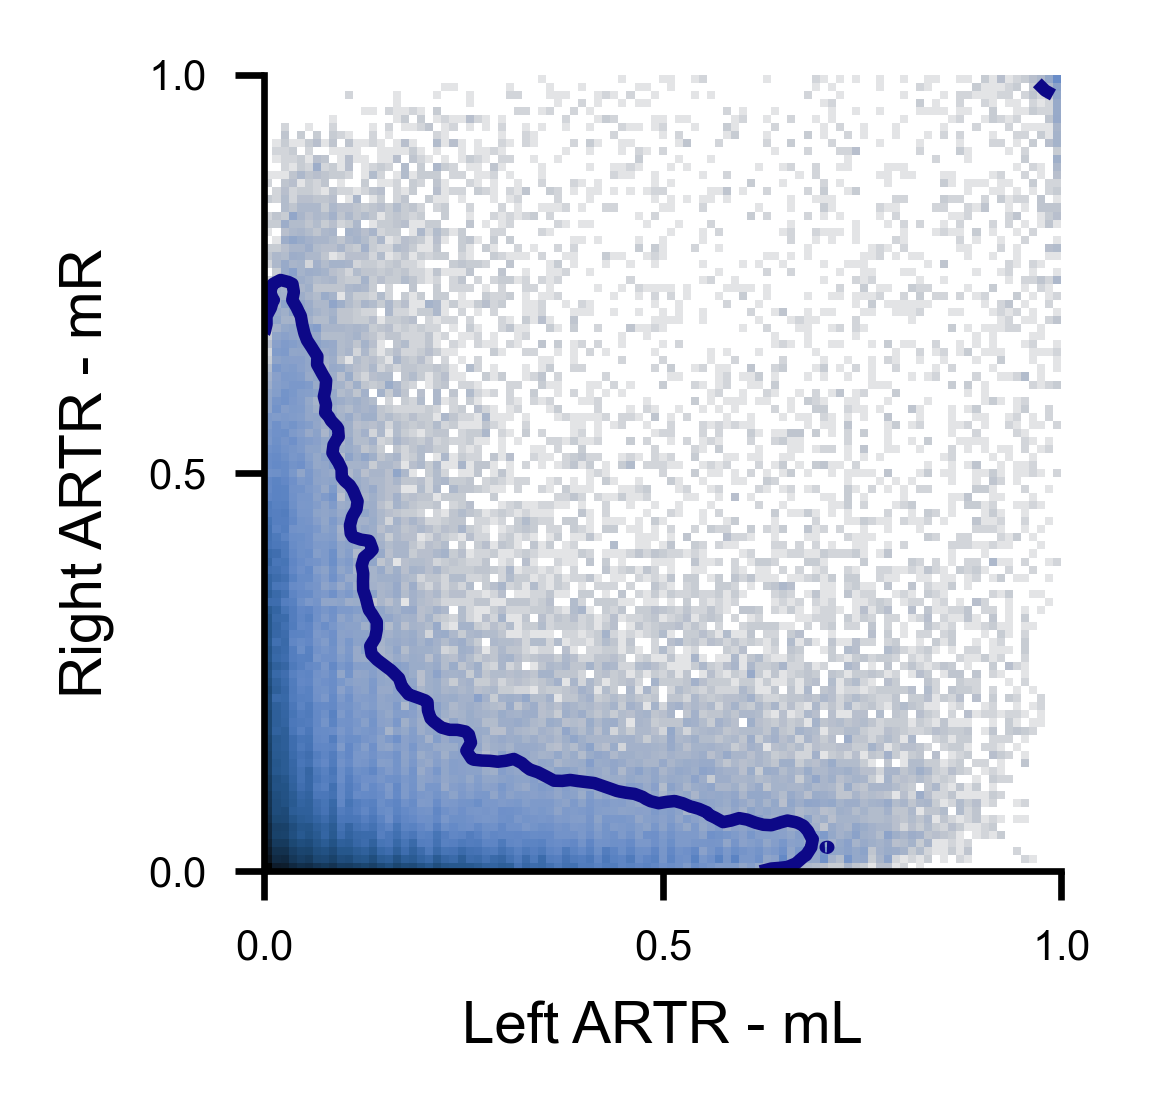

In [358]:
fig, ax = plt.subplots(figsize=(1.8,1.8))
cmap = cmc.oslo_r
cmap.set_bad(cmap(0))
z,x,y,hh = ax.hist2d(mLRall[:,0], mLRall[:,1], bins=np.linspace(0,1,100), cmap=cmap, density=True, rasterized=True, norm=LogNorm());

#CS = ax.contour(x[:-1], y[:-1], gaussian_filter(z, 1), [0.3])
CS = ax.contour(x[:-1], y[:-1], gaussian_filter(z, 1), [find_level(z, 0.90)])
#ax.clabel(CS, inline=True, fontsize=10, fmt={CS.levels[0]:"90%"})

#cbar = fig.colorbar(hh, ax=ax, label="Density", shrink=0.55)
#cbar.add_lines(CS)

ax.set_xlabel("Left ARTR - mL")
ax.set_ylabel("Right ARTR - mR")
ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

ax.set_aspect('equal')
fig.savefig("panels/Fig1/magnetization.svg")

# Supplementaries

## Nb and lenght of trajectories

In [365]:
all_temps = []
for temp in TEMPS:
    X = load_sequences(bDATAPATH, temp)
    all_temps.append(X)

In [366]:
nb_trajs = [len(a) for a in all_temps]
print(f"Nb of trajs : min={min(nb_trajs)} , max={max(nb_trajs)} , mean={np.mean(nb_trajs):.0f}")

Nb of trajs : min=532 , max=1513 , mean=1148


In [367]:
len_trajs = np.concatenate([[len(t) for t in a] for a in all_temps])
print(f"Length of trajs : min={min(len_trajs)} , max={max(len_trajs)} , mean={np.mean(len_trajs):.0f}")

Length of trajs : min=9 , max=748 , mean=60


Text(0.5, 0, 'Number of bouts per trajectory')

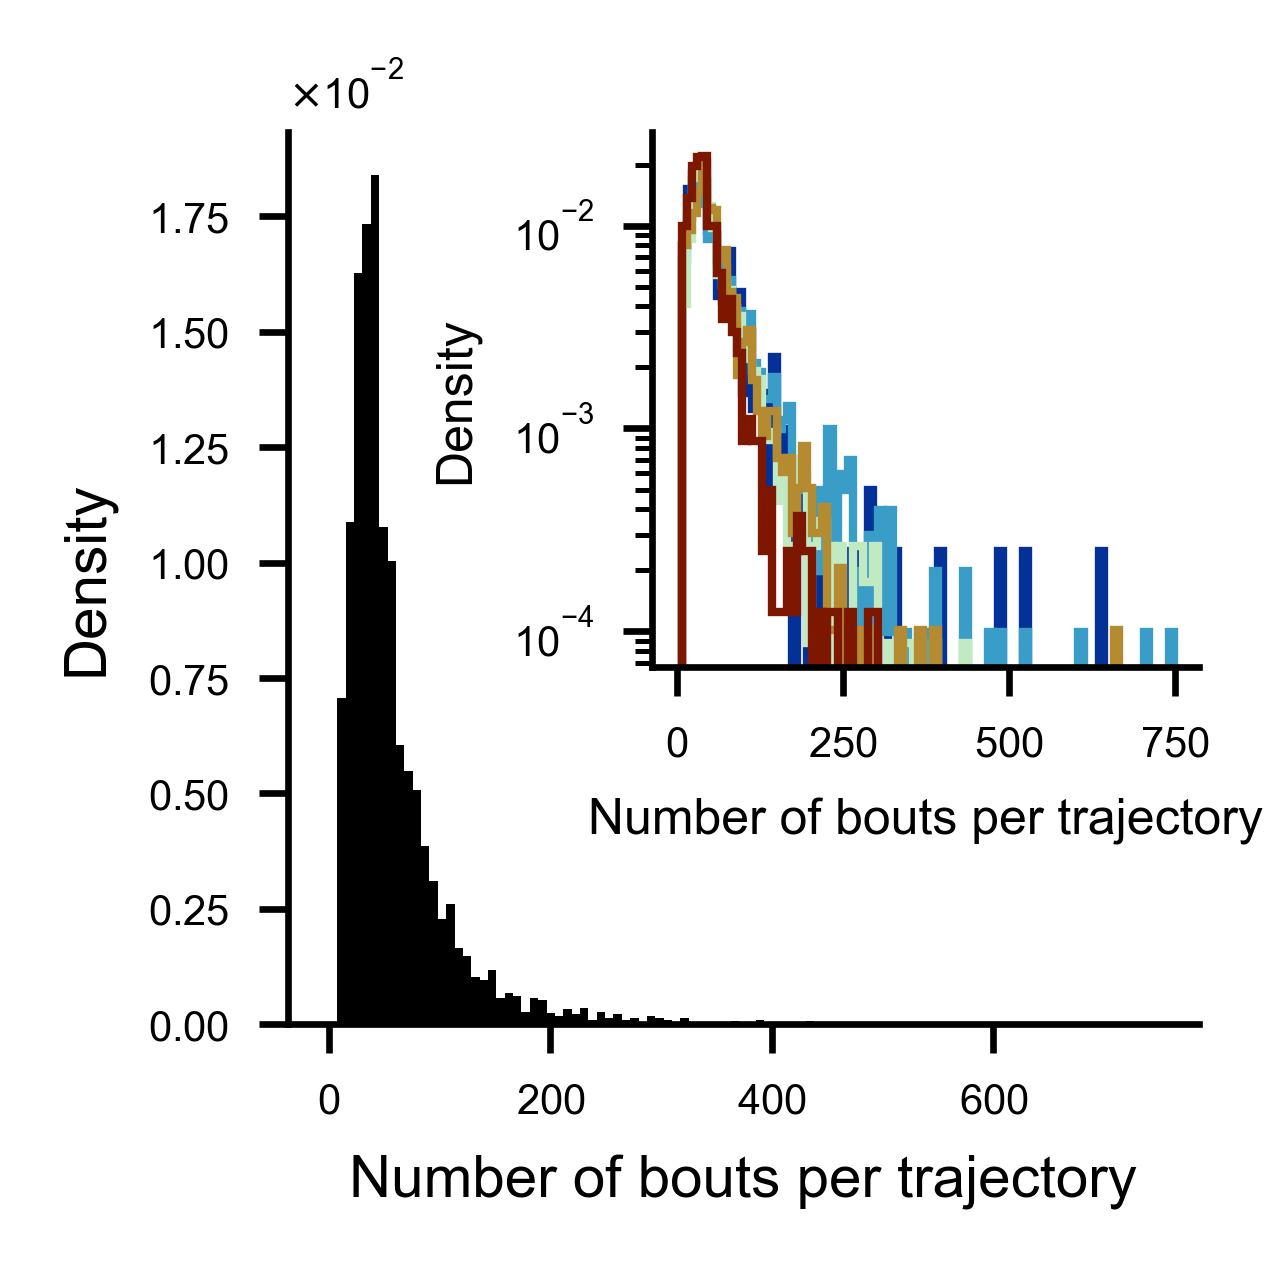

In [369]:
fig, ax = plt.subplots()
bins = np.linspace(0,max(len_trajs), 100)
#xlabs = np.
ax.hist(len_trajs, bins, density=True, histtype="stepfilled");
ax.ticklabel_format(axis="y", style="sci", scilimits=(-2,1))
ax.set_xlabel("Number of bouts per trajectory")
ax.set_ylabel("Density")

axin = ax.inset_axes((0.4,0.4, 0.6,0.6))
for temp in TEMPS:
    X = load_sequences(bDATAPATH, temp)
    lens = [len(a) for a in X]
    axin.hist(lens, bins, histtype="step", density=True, color=TEMPS_COLS[temp])
axin.set_yscale("log")
axin.set_ylabel("Density", fontdict={"fontsize":6})
axin.set_xlabel("Number of bouts per trajectory", fontdict={"fontsize":6})


#fig.savefig(f"panels/Fig1/supps/nb_bouts.svg")

## Exploration of deltatheta :   $\delta\theta_{n+1} (\delta\theta_{n})$

In [370]:
from matplotlib.colors import LogNorm

In [371]:
def angle_pseudomarkov(sequences, q=1):
    q = 20
    x, y = [], []
    for seq in sequences:
        for i in range(len(seq)-q):
            x.append(seq[i])
            y.append(seq[i+q])
    return np.array(x), np.array(y)

In [372]:
X = load_sequences(bDATAPATH, 18) \
    + load_sequences(bDATAPATH, 22) \
    + load_sequences(bDATAPATH, 26) \
    + load_sequences(bDATAPATH, 30) \
    + load_sequences(bDATAPATH, 33)

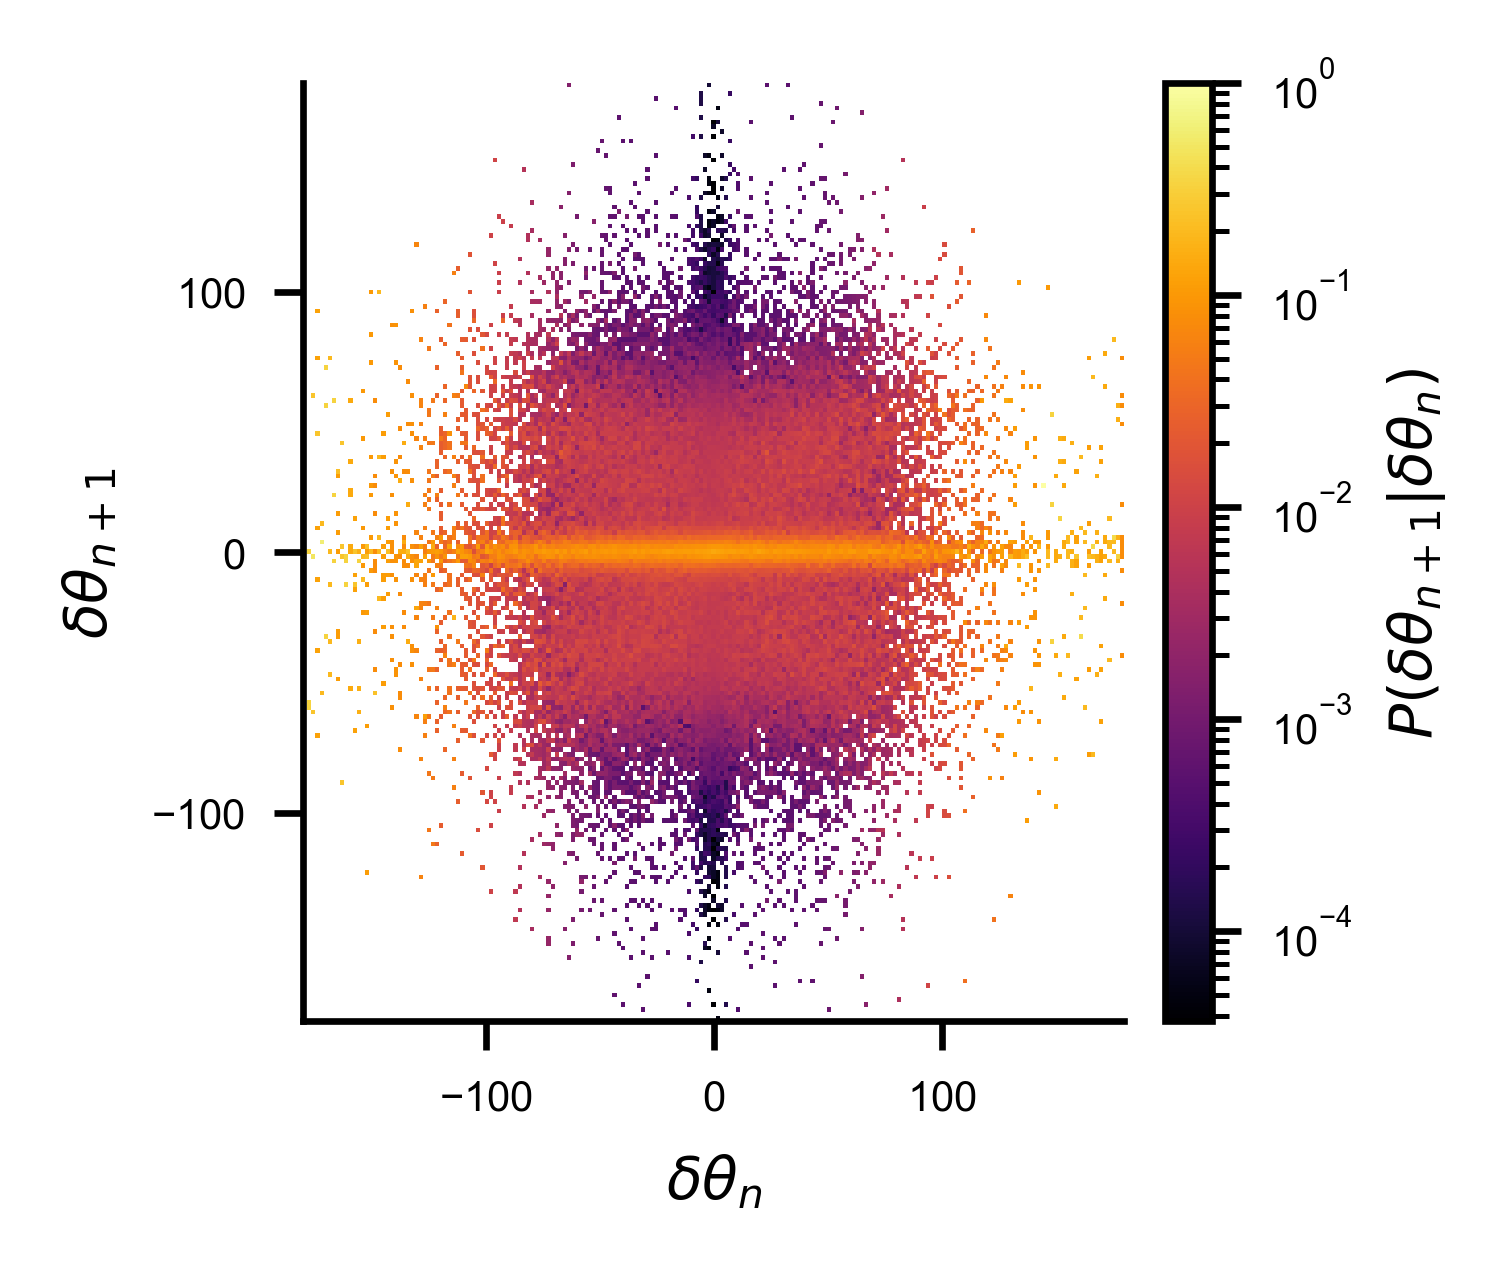

In [373]:
x,y = angle_pseudomarkov(X)
n = 200
bins = np.linspace(-180, +180, n)
H, bx, by = np.histogram2d(x,y,bins)

T = H / H.sum(axis=1)[:,np.newaxis]

fig, ax = plt.subplots(figsize=(1.2*2,2))
ax.set_aspect("equal")
h=ax.imshow(
    T.T, 
    norm=LogNorm(),
    cmap="inferno",
    extent = (
        bx.min(),
        bx.max(),
        by.min(),
        by.max()
    ),
    rasterized=True
)
ax.set_xlabel(r"$\delta\theta_{n}$")
ax.set_ylabel(r"$\delta\theta_{n+1}$")
ax.set_xticks([-100,0,+100])
ax.set_yticks([-100,0,+100])
fig.colorbar(h, ax=ax, label=r"$P(\delta\theta_{n+1} | \delta\theta_{n})$")

fig.savefig(f"panels/Fig1/supps/angles_transitions.svg")

## ARTR Magnet hist

In [374]:
from scipy.signal import savgol_filter

In [391]:
artrs = np.array([load_ARTR_magnet(nDATAPATH, *artr) for artr in ALL_ARTRs], dtype=object)
mLRtemps = [
    np.concatenate(
        artrs[np.where(ALL_ARTRs[:,1] == temp)[0]]
    ) for temp in TEMPS
]

Text(0, 0.5, 'Density')

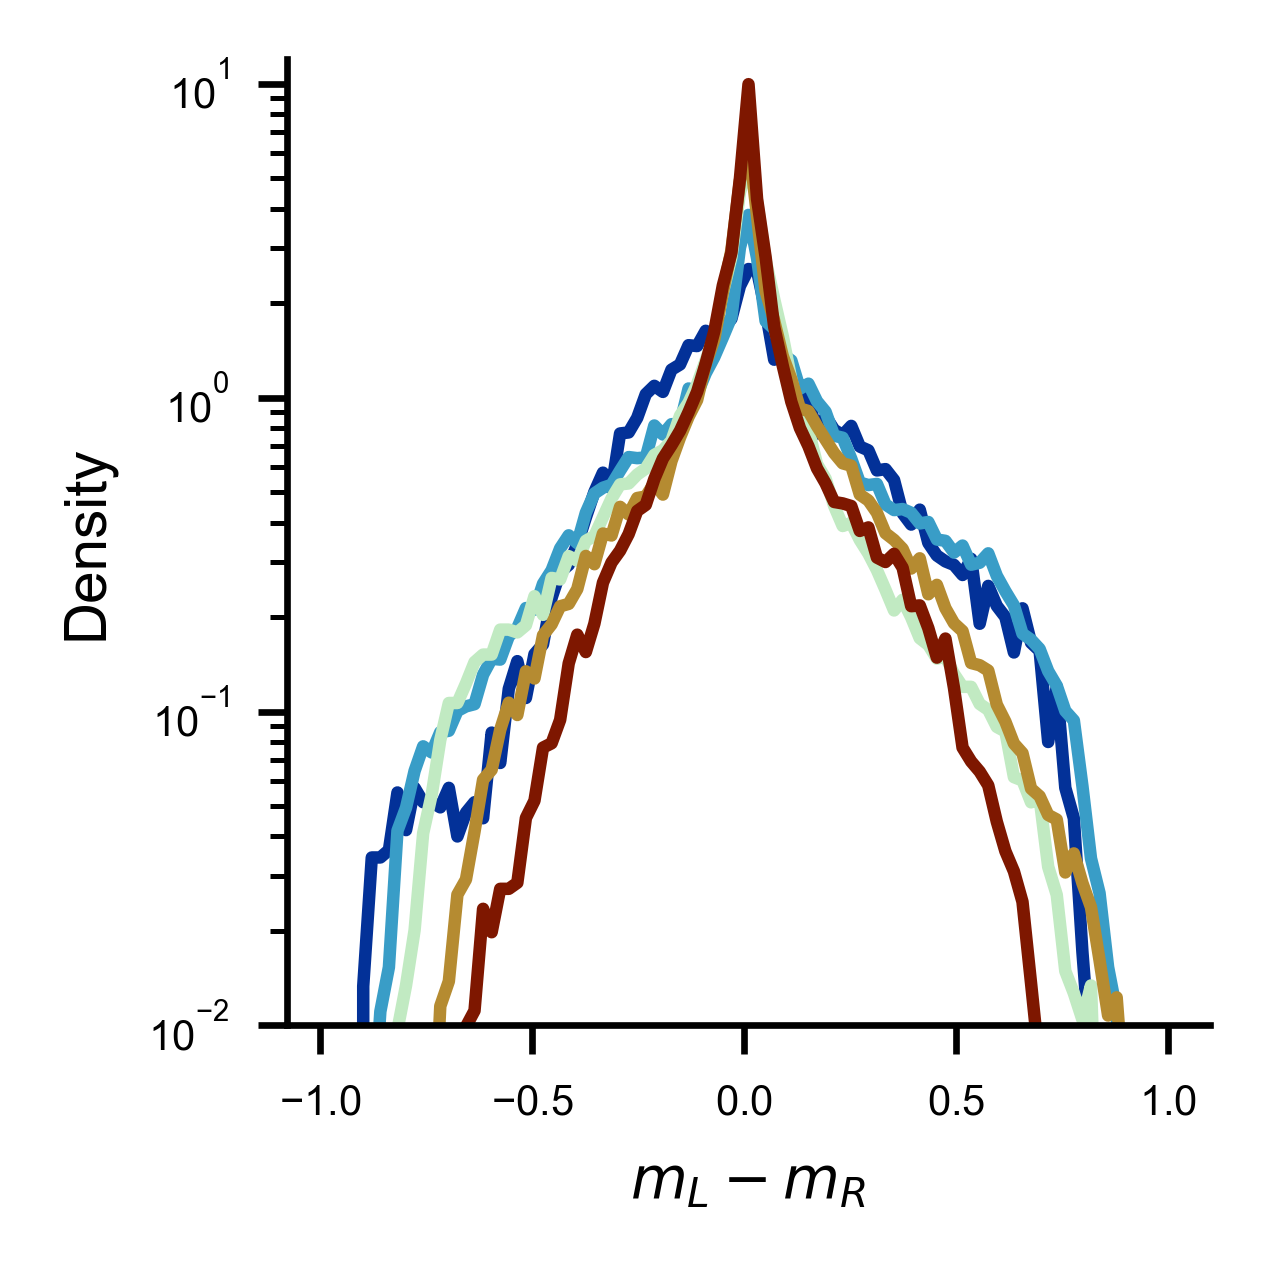

In [392]:
fig, ax = plt.subplots()
bins = np.linspace(-1, +1, 100)
for i, temp in enumerate(TEMPS[:5]):
    x = mLRtemps[i][:,0] - mLRtemps[i][:,1]
    h,_ = np.histogram(x, bins, density=True)
    ax.plot(bins[1:], h, color=TEMPS_COLS[temp])
    
ax.set_yscale("log")
ax.set_ylim(1.e-2,1.2e+1)
ax.set_xlabel(r"$m_L - m_R$")
ax.set_ylabel("Density")

fig.savefig(f"panels/Fig1/supps/ARTR_magnetization.svg")